In [1]:
# ------- LIBRARIES ------ #
import db_pull_funcs as db_pull
import pipes_fitting_funcs as p_fit
import pipes_plotting_funcs as p_plot

import bagpipes as pipes
import numpy as np

from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import Planck13 as cosmo

import time

from tabulate import tabulate

Set ROOT_PATH=/workspaces/dja-pipes/dja-pipes/notebooks
Bagpipes: Latex distribution not found, plots may look strange.
Bagpipes: PyMultiNest import failed, fitting will use the Nautilus sampler instead.


### pulling spectrum and photometry from the AWS database

In [2]:

fname = 'rubies-egs51-v3_prism-clear_4233_19489'

fname_spec = fname+'.spec.fits'
fname_phot = fname+'.phot.cat'

fname_spec_out = 'file_for_pipes.spec.fits'
fname_phot_out = 'file_for_pipes.phot.cat'

filePath = '../files/'


In [3]:
db_pull.pull_spec_from_db(fname_spec, fname_spec_out, filePath)

In [4]:
db_pull.pull_phot_from_db(fname_spec, fname_phot_out, filePath)

#### plotting observed spectrum and photometry

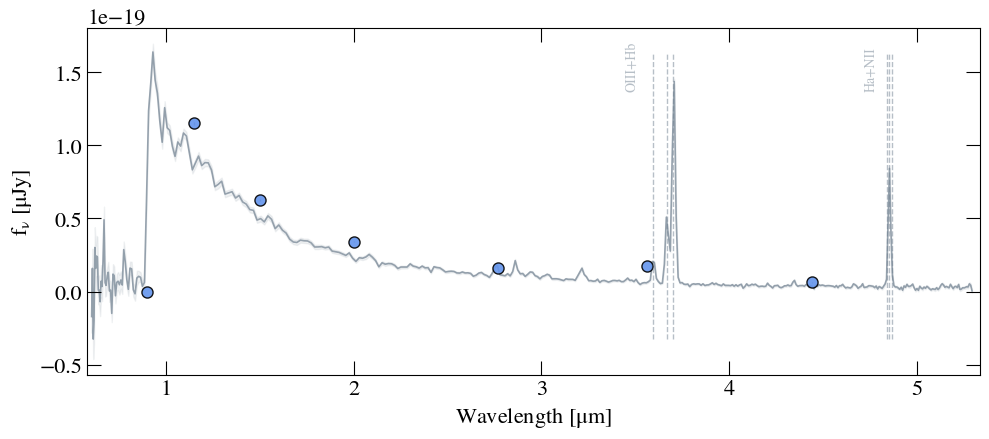

In [5]:
p_plot.plot_spec_phot_data(fname_spec_out, fname_phot_out, f_lam=True)

In [6]:
# spectrum
spec_tab = Table.read(f'../files/{fname_spec_out}', hdu=1)

# photometry
phot_tab = Table.read(f'../files/{fname_phot_out}', format='ascii.commented_header')

# spectroscopic redshift
z_spec = phot_tab['z_spec'].value[0]
print("zspec:\t", z_spec)

zspec:	 6.394


# BAGPIPES SED fitting

### model paramaters

In [7]:
def fitting_params(z_spec, sfh="continuity", scale_disp=1, use_msa_resamp=False, fit_agn=False, fit_dla=False):

    fit_instructions = {}
    
    ## ---------- ## double power-law sfh (parametric)
    dblplaw = {}                        
    dblplaw["tau"] = (0., 15.)            
    dblplaw["alpha"] = (0.01, 1000.)
    dblplaw["beta"] = (0.01, 1000.)
    dblplaw["alpha_prior"] = "log_10"
    dblplaw["beta_prior"] = "log_10"
    dblplaw["massformed"] = (1., 13.)
    dblplaw["metallicity"] = (0.003, 2.)
    dblplaw["metallicity_prior"] = "log_10"

    
    ## ---------- ## delayed-tau sfh (parametric)
    delayed = {}                         # Delayed Tau model t*e^-(t/tau)
    delayed["age"] = (0.1, 9.)           # Time since SF began: Gyr
    delayed["tau"] = (0.1, 9.)           # Timescale of decrease: Gyr
    delayed["massformed"] = (6., 13.)
    delayed["metallicity"] = (0.2, 1.)   # in Zsun

    
    ## ---------- ## continuity sfh (non-parametric)
    def get_age_bins(z):
        max_age = cosmo.age(z).to('Myr').value - cosmo.age(20).to('Myr').value
        age_bins = [0., 10.,]
        for i in np.logspace(1.5, np.log10(max_age), 6):
            age_bins.append(i)
        
        return age_bins
    
    continuity = {}
    continuity["massformed"] = (6., 14.)
    continuity["metallicity"] = (0.01, 3.)
    continuity["metallicity_prior"] = "log_10"
    continuity["bin_edges"] = get_age_bins(z_spec)
    
    for i in range(1, len(continuity["bin_edges"])-1):
        continuity["dsfr" + str(i)] = (-10., 10.)
        continuity["dsfr" + str(i) + "_prior"] = "student_t"
        continuity["dsfr" + str(i) + "_prior_scale"] = 1.0   # Defaults to 0.3 as in Leja19, but can be set - 1 is bursty continuity prior from Tacchella+21
        continuity["dsfr" + str(i) + "_prior_df"] = 2       # Defaults to this value as in Leja19, but can be set
    
    continuity["age_min"] = 0


    # setting the preferred sfh
    if sfh=="continuity":
        fit_instructions["continuity"] = continuity
    elif sfh=="dblplaw":
        fit_instructions["dblplaw"] = dblplaw
    elif sfh=="delayed":
        fit_instructions["delayed"] = delayed

    
    ## ---------- ## nebular emisison, logU
    nebular = {}
    nebular["logU"] = (-4., -1.)
    nebular["logU_prior"] = "Gaussian"
    nebular["logU_prior_mu"] = -2.25
    nebular["logU_prior_sigma"] = 0.25
    fit_instructions["nebular"] = nebular

    
    ## ---------- ## dust law
    dust = {}
    dust["type"] = "Calzetti"            # Define the shape of the attenuation curve
    dust["Av"] = (0., 4.)                # Vary Av between 0 and 4 magnitudes
    # dust["type"] = "CF00"
    # dust["eta"] = 2.
    # dust["Av"] = (0., 2.0)
    # dust["n"] = (0.3, 2.5)
    # dust["n_prior"] = "Gaussian"
    # dust["n_prior_mu"] = 0.7
    # dust["n_prior_sigma"] = 0.3
    fit_instructions["dust"] = dust

    
    ## ---------- ## agn component
    agn = {}
    agn["alphalam"] = (-2., 2.)
    agn["betalam"] = (-2., 2.)
    agn["f5100A"] = (0, 1e-19)
    agn["sigma"] = (1e3, 5e3)
    agn["hanorm"] = (0,2.5e-17)

    if fit_agn:
        fit_instructions["agn"] = agn
    
    
    ## ---------- ## tight redshift prior around z_spec
    fit_instructions["redshift"] = (z_spec - 0.001*(1+z_spec), z_spec + 0.001*(1+z_spec))
    fit_instructions["redshift_prior"] = "Gaussian"
    fit_instructions["redshift_prior_mu"] = z_spec
    fit_instructions["redshift_prior_sigma"] = 0.001 * (1+z_spec)

    
    ## ---------- ## jwst prism resolution curve
    hdul = fits.open("../files/jwst_nirspec_prism_disp.fits")
    resData = np.c_[10000*hdul[1].data["WAVELENGTH"], hdul[1].data["R"]*scale_disp]
    fit_instructions["R_curve"] = resData

    
    ## ---------- ## boolean for using msa resampling
    fit_instructions["use_msa_resamp"] = use_msa_resamp

    
    ## ---------- ## fixed velocity dispersion
    fit_instructions["veldisp"] = 100.   #km/s

    ## ---------- ## dla component (doesn't work?)
    dla = {}
    dla["zabs"] = z_spec
    dla["t"] = 22.
    if fit_dla:
        fit_instructions["dla"] = dla

    
    ## ---------- ## calibration curve (2nd order polynomial)
    calib = {}
    calib["type"] = "polynomial_bayesian"
    
    calib["0"] = (0.5, 1.5) # Zero order is centred on 1, at which point there is no change to the spectrum.
    calib["0_prior"] = "Gaussian"
    calib["0_prior_mu"] = 1.0
    calib["0_prior_sigma"] = 0.25
    
    calib["1"] = (-0.5, 0.5) # Subsequent orders are centred on zero.
    calib["1_prior"] = "Gaussian"
    calib["1_prior_mu"] = 0.
    calib["1_prior_sigma"] = 0.25
    
    calib["2"] = (-0.5, 0.5)
    calib["2_prior"] = "Gaussian"
    calib["2_prior_mu"] = 0.
    calib["2_prior_sigma"] = 0.25
    
    fit_instructions["calib"] = calib

    
    ## ---------- ##
    mlpoly = {}
    mlpoly["type"] = "polynomial_max_like"
    mlpoly["order"] = 2


    ## ---------- ## white noise scaling
    noise = {}
    noise["type"] = "white_scaled"
    noise["scaling"] = (1., 10.)
    noise["scaling_prior"] = "log_10"
    fit_instructions["noise"] = noise

   
    

    return(fit_instructions)

In [8]:

index = "0" # run ID
int_index = int(index)

# jwst filter list
filt_list = np.loadtxt("../filters/filt_list.txt", dtype="str")

# making galaxy object
galaxy = pipes.galaxy(index, p_fit.load_both, filt_list=filt_list,
                      spec_units='ergscma',
                      phot_units='muJy',
                      out_units="ergscma")

# scaling resolution curve
scale_disp=1.3

# generating fit instructions
fit_instructions = fitting_params(z_spec, sfh="continuity", scale_disp=scale_disp, use_msa_resamp=True, dla=True)
# making fit object
fit = pipes.fit(galaxy, fit_instructions, run='test')

# fit object
fit.fit(verbose=False, sampler='nautilus', pool=4)



Results loaded from pipes/posterior/test/0.h5

Fitting not performed as results have already been loaded from pipes/posterior/test/0.h5. To start over delete this file or change run.



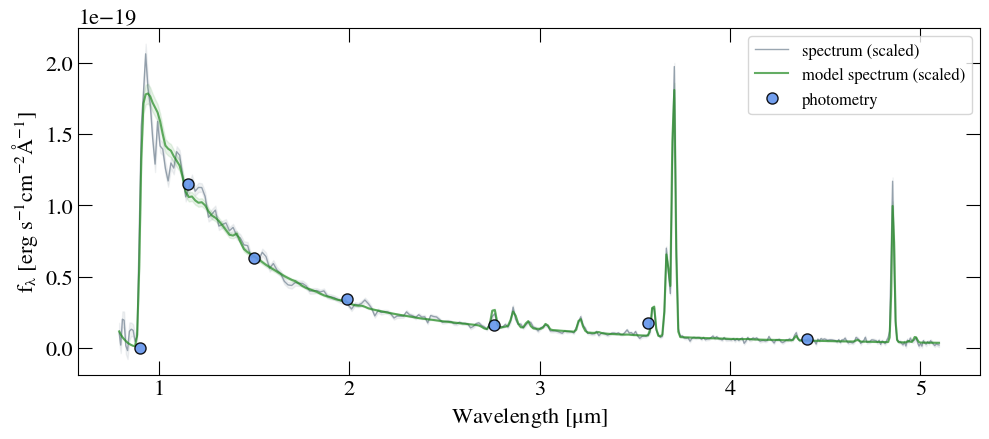

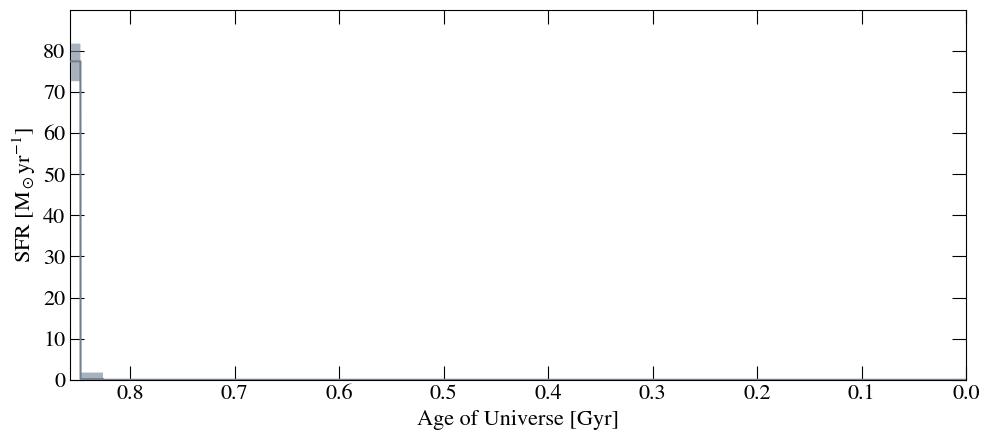

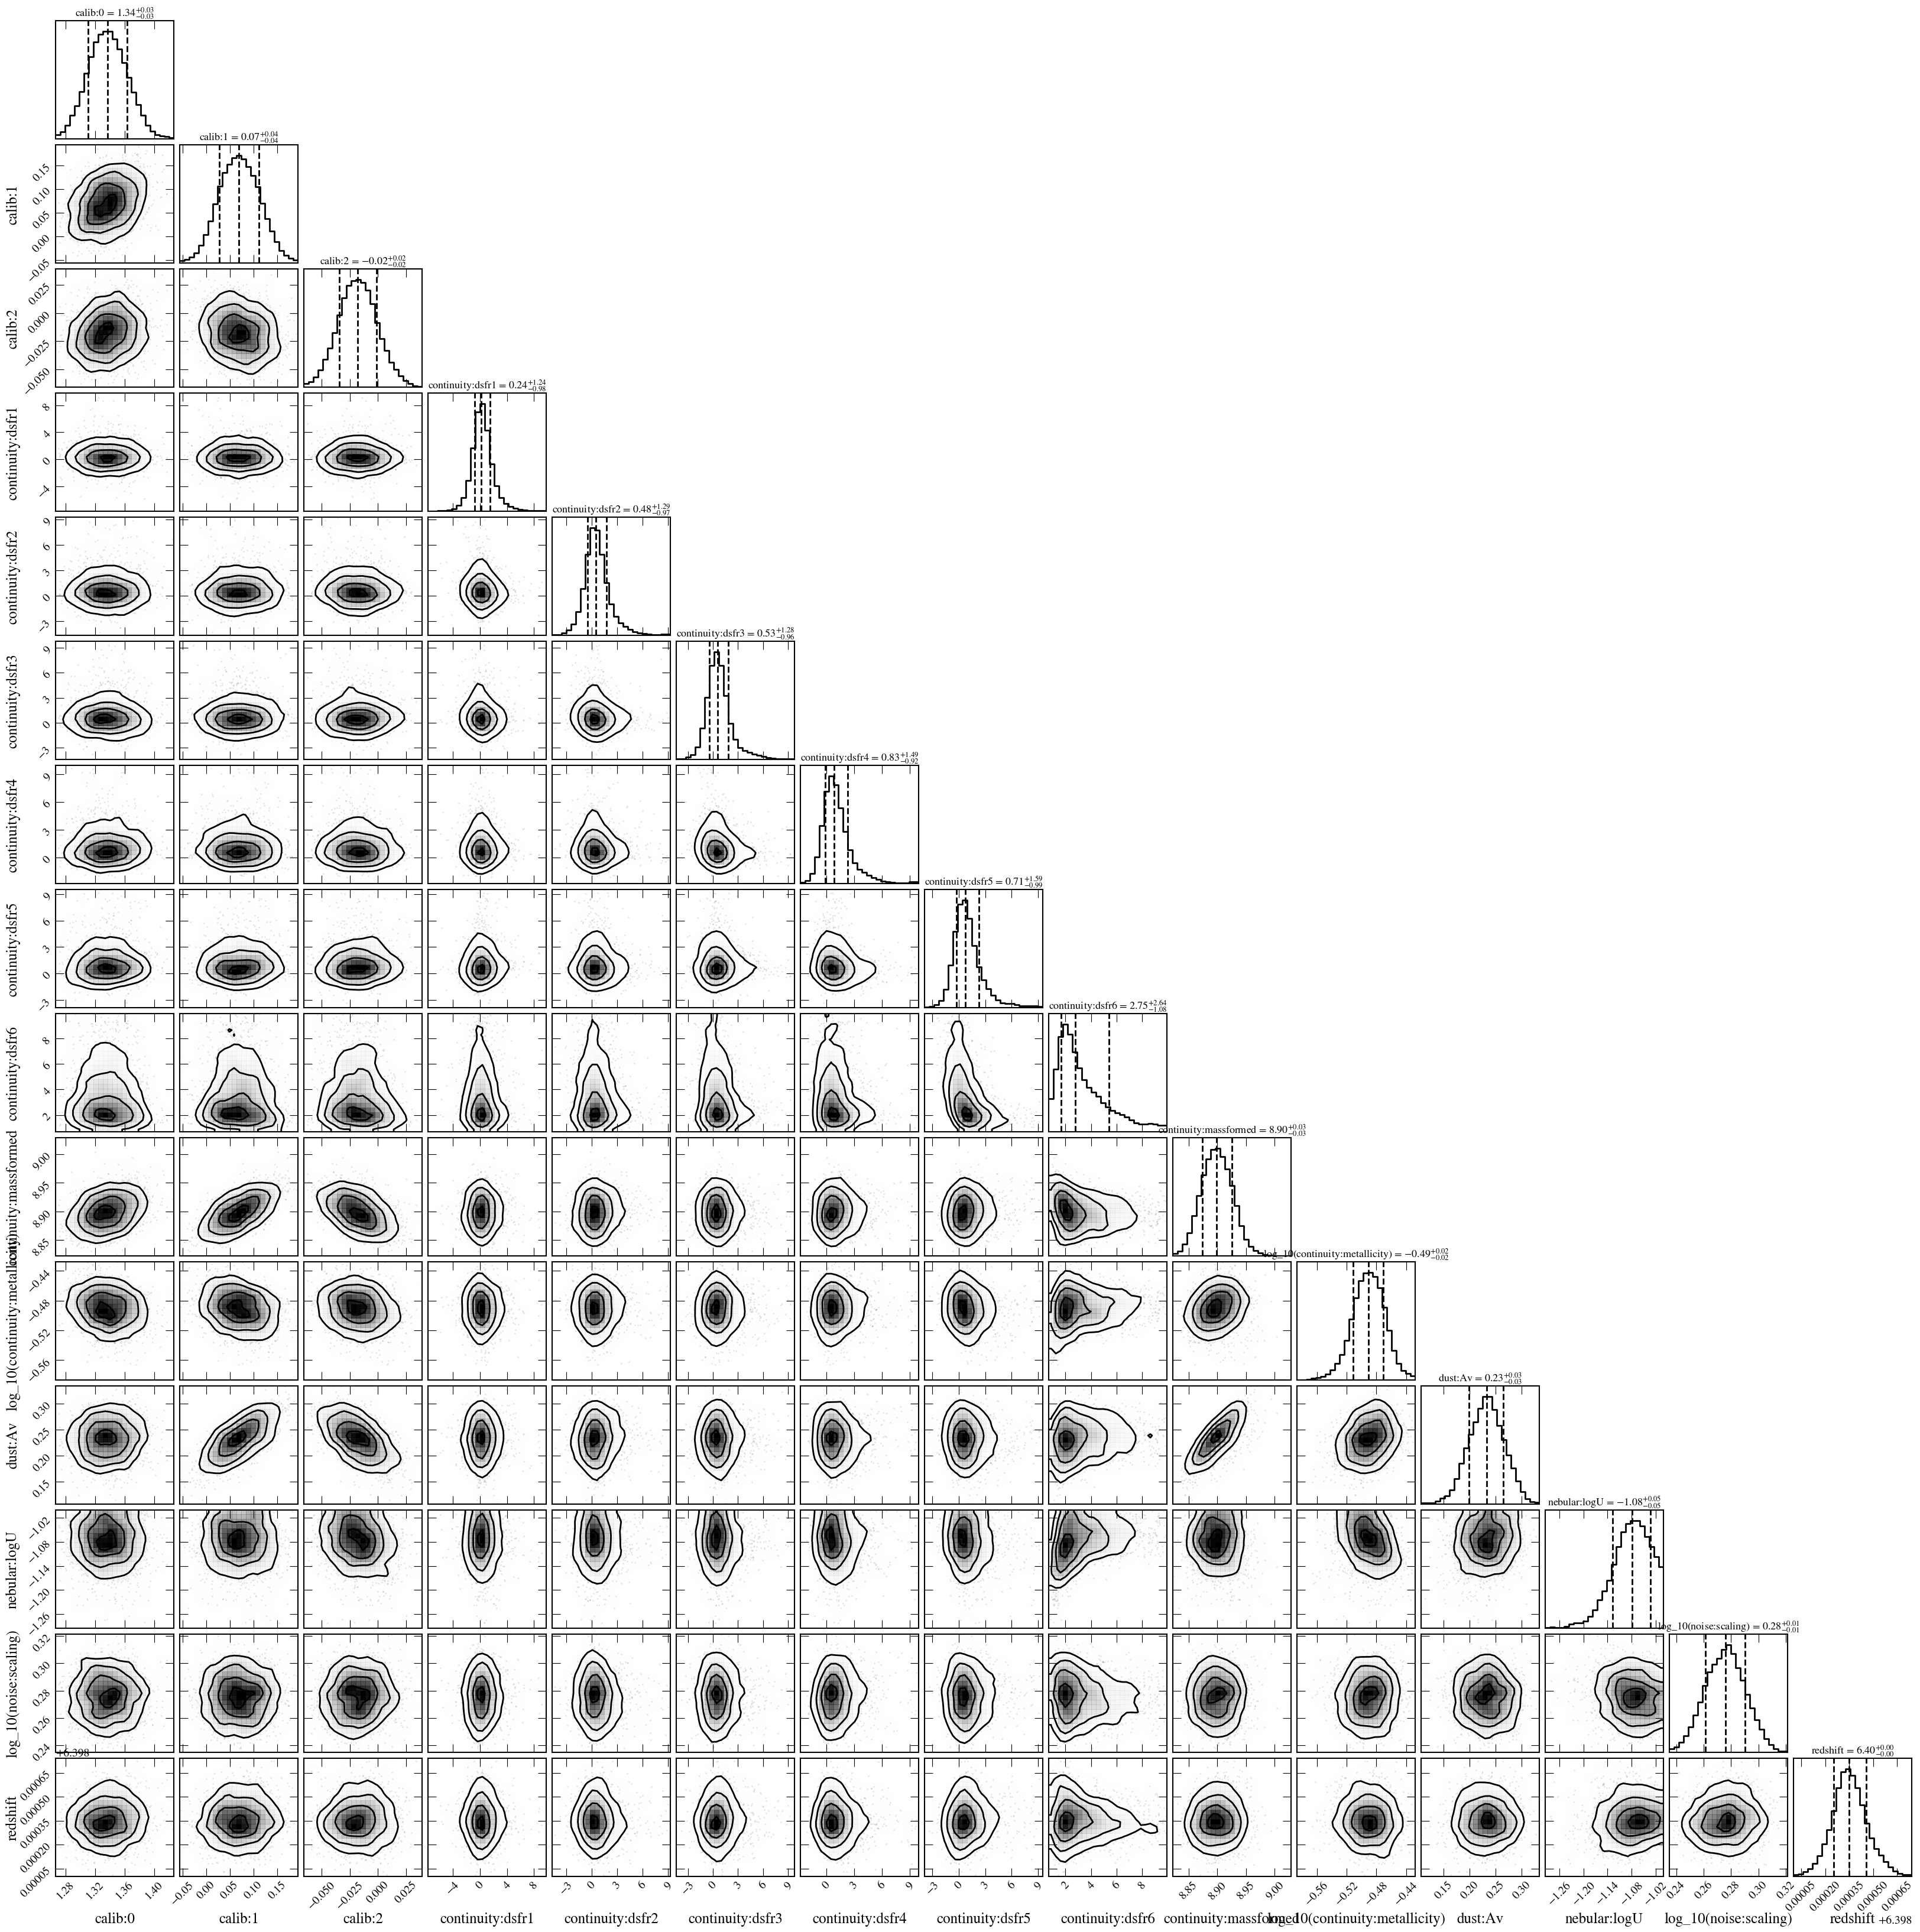

In [9]:
# plotting fitted model and star-formation history

fig = p_plot.plot_fitted_spectrum(fit)
fig = p_plot.plot_fitted_sfh(fit)
fig = fit.plot_corner(save=False, show=True)

In [10]:
# table of posterior fitted quantities

tab = p_plot.get_posterior_sample_dists(fit)
print(tabulate(np.array(tab),headers=["Parameter", "16th %", "50th %", "84th %"], tablefmt="github"))

| Parameter              |   16th % |   50th % |   84th % |
|------------------------|----------|----------|----------|
| calib:0                |    1.311 |    1.336 |    1.363 |
| calib:1                |    0.028 |    0.068 |    0.111 |
| calib:2                |   -0.034 |   -0.018 |    0.001 |
| continuity:dsfr1       |   -0.88  |    0.277 |    1.339 |
| continuity:dsfr2       |   -0.513 |    0.561 |    1.735 |
| continuity:dsfr3       |   -0.435 |    0.449 |    1.789 |
| continuity:dsfr4       |   -0.187 |    0.784 |    2.417 |
| continuity:dsfr5       |   -0.271 |    0.814 |    2.487 |
| continuity:dsfr6       |    1.638 |    2.645 |    5.217 |
| continuity:massformed  |    8.873 |    8.898 |    8.927 |
| continuity:metallicity |    0.307 |    0.323 |    0.339 |
| dust:Av                |    0.199 |    0.231 |    0.264 |
| nebular:logU           |   -1.124 |   -1.073 |   -1.032 |
| noise:scaling          |    1.822 |    1.889 |    1.949 |
| redshift               |    6.398 |   